# Colliders

Today we'll introduce the final main type of causal structure: the collider. This will give the tools to spell out a complete theory of causal reasoning. Very complicated causal systems can be decomposed into a network of colliders, common causes and mediators. By applying the a set of three rules, we can figure out exactly what we have to measure and include in a statistical model to identify a causal effect. The point of all this is to help to develop some rules for understanding how different causal systems correspond to different statistial models.

To introduce colliders, I want to start by telling you my thoughts on Vancouver's restaurants. My favourite restaurant is the Dosa Factory. They serve these massive, hot delicious dosas stuffed with curry, paneer and potatoes. The prices are alright too. On Monday, they run a special where you get a full meal for about 10 dollars. It's on King Edward and Knight. The only trouble is the location. It takes about an hour to get there from UBC. It still takes an hour from downtown. The nearest skytrain station is about a 20 minute walk away and the only bus on the route is pretty slow.

My least favourite restaurant is the Steamworks in Gas town. It's a gaint restaurant in a pristine location and beautiful view of the harbour. It's right by the waterfront skytrain. They always have available seating. The food tastes extremely bland. It's like paying \$25 dollars for Applebees. 

It feels like this pattern holds up generally: the best restaurants are in the worst locations and the worst restaurants are in the best locations. Or, consider Subway. Whenever you are lost and alone in the middle of nowhere, Subway is there for you. It's not gonna taste good. But it's always close be. So it feels like there is a robust association. But what explains this association? Could it be that being in a good location causes your food to get worse?

Here's another theory: in order to stay in business, restaurants need a certain amount of profitability. Unprofitable restraurants close down. Profitability can come from two sources: good food and a good location. Once you have a certain mix of both of them, you're good.

In [6]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import stats
from graphviz import Digraph

The causal graph I have in mind looks like this:

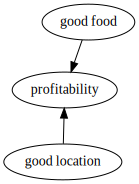

In [54]:
dot = Digraph()
dot.graph_attr['layout'] = 'neato'

dot.node("a",'good food',pos="200,400")
dot.node("b",'profitability',pos="0,200")
dot.node("c","good location",pos="100,0")

dot.edge("a",'b',len='1.0')
dot.edge("c",'b',len='1.0')

dot

I want to show you that it is possible to induce a negative correlation between food and location even though neither one causes the other. Let's build a simulation where business (or profitability) is a function of food and location. But we'll stipulate that there is zero causal effect between the two of them.

In [57]:
sample_size = 200

food = stats.norm(0,1).rvs(sample_size)
location = stats.norm(0,1).rvs(sample_size)

business = food + location + stats.norm(0,1).rvs(sample_size)

Both food and location are just randomly generated values. So there shouldn't be any apparent pattern in this data. The plot shows they are uncorrelated.

Text(0, 0.5, 'Quality of location')

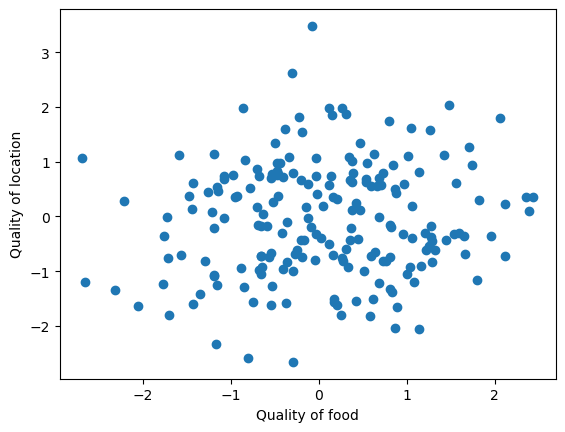

In [58]:
plt.plot(food,location,'o')
plt.xlabel("Quality of food")
plt.ylabel("Quality of location")

Now i'm going to filter out all the restaurants that don't meet a certain threshold in profits. Let's say if your profits score is less than one, you go out of business. I'll plot the same data but now restaurants that went out of business are transparent circles.

Text(0, 0.5, 'Quality of location')

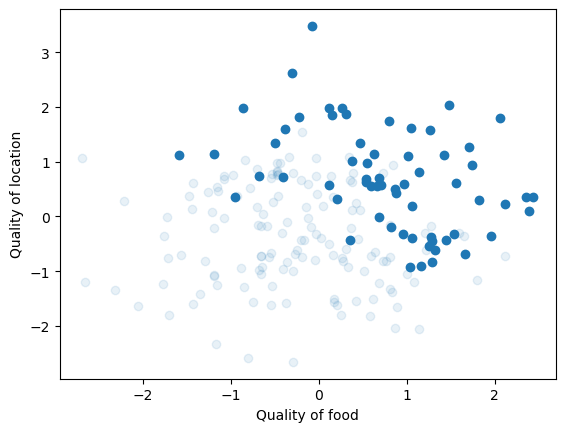

In [76]:
success = business > 1
food_filter = food[success]
location_filter = location[success]
plt.plot(food,location,'o',alpha=0.1,color="tab:blue")
plt.plot(food_filter,location_filter,'o',color="tab:blue")
plt.xlabel("Quality of food")
plt.ylabel("Quality of location")

If you only look at the opaque dots it looks like there is a modest negative correlation between quality of food and quality of location! If you tried to draw a line through the opaque blue dots, it would take on a downward slope. But there wasn't really a causal relation to begin with! It just looks like there is a causal relation because of the effect of profitability. A statistical model would erroneously think there is a causal effect. For example, this one finds a modest negative effect from food to location.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Baseline location, Food, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


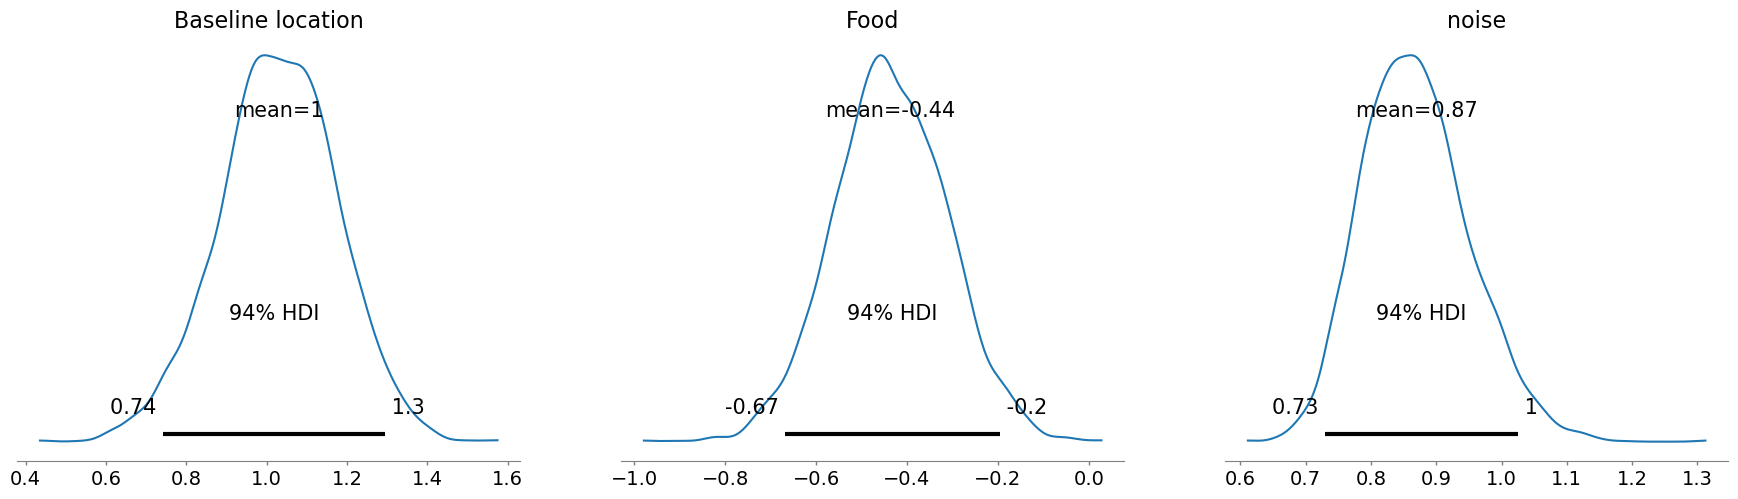

In [60]:
with pm.Model() as collider_bias_with_filters:
    
    a = pm.Normal('Baseline location',0,50)
    b = pm.Normal('Food',0,50)
    s = pm.Exponential('noise',1)
    
    mean = a + b*food_filter
    
    y = pm.Normal('location',mean,s,observed=location_filter)
    
    trace = pm.sample()
    
az.plot_posterior(trace);

The feeling that having good food causes restaurants to open in bad locations is a product of the fact that we only get to eat at the restaurants that survive in the market. You don't get to eat at all the restaurants that never made it. If we could fairly sample from the hypothetical space of possible restaurants, we could learn that they genuinely are uncorrelated. But we are not that lucky. The data we have access to is molded by the collider.

## Participant bias as a collider

Colliders are really hard to understand. They are able to produce very counterintuitive non-causal relationships between variables that boggle the mind. Our brains are good at spotting patterns and trying to come up with causal explanations for them. We often cling to causal explanations even when they don't make much sense because the alternative is to just allow mysterious patterns to float about. But colliders induce non-causal patterns. So we are often at a loss to explain how they work. 

Let me give you another example. In the early days of the pandemic, people believed the weirdest things. One early research finding was that smokers have a lower risk of severe covid. The theory seemed to be: what doesn't kill you makes you stronger, therefore smokers must have tough lungs to resist covid. That's preposterous. A few months later, a better explanation was well-understood: collider-bias. 

Here is how it works. Smoking increases your risk of going to the hospital for respiratory disease. Covid also does the same. Now studies, in the early days, were only conducted on people in the hospitals. For people who didn't check into the hospital, we do not have data on them. Checking into the hospital, much like keeping a restaurant open, is a product of two different causes. When we running a study on hospitalized patients, we are implicitly including it as a potential cause of covid. And we can induce spurious negative associations between smoking and covid.

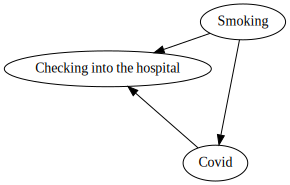

In [77]:
dot = Digraph()
dot.graph_attr['layout'] = 'neato'

dot.node("a",'Smoking',pos="200,400")
dot.node("b",'Checking into the hospital',pos="0,200")
dot.node("c","Covid",pos="100,0")

dot.edge("a",'b',len='2.0')
dot.edge("c",'b',len='2.0')
dot.edge("a",'c',len='2.0')

dot

Again, simulations help clear all this up. In this simulation, we assume that smoking *increases* your risk of getting covid. So we've built in a genuine adverse effect of smoking into the model.

In [49]:
n = 100

smoking = stats.norm(0,1).rvs(n)
covid = 1 + 0.5 * smoking + stats.norm(0,1).rvs(n)
hospital = -4 + 3 * smoking + 2 * covid + stats.norm(0,2).rvs(n)

However, when you incldue both hospitalization and smoking as causes in the statistical model, it tells us that smoking has a small negative effect on coviding. Or, in plain english, smokers are less likely to experience severe covid. This explains where the weird headlines early in the pandemic came from. As I mentioned, our brains latch onto statistical correlations expecting there to be a causal relationship underneath them. In the case of collider bias, it's a statistical correlation with no real causal relationship.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline covid level, Smoking effect, Covid test effect, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


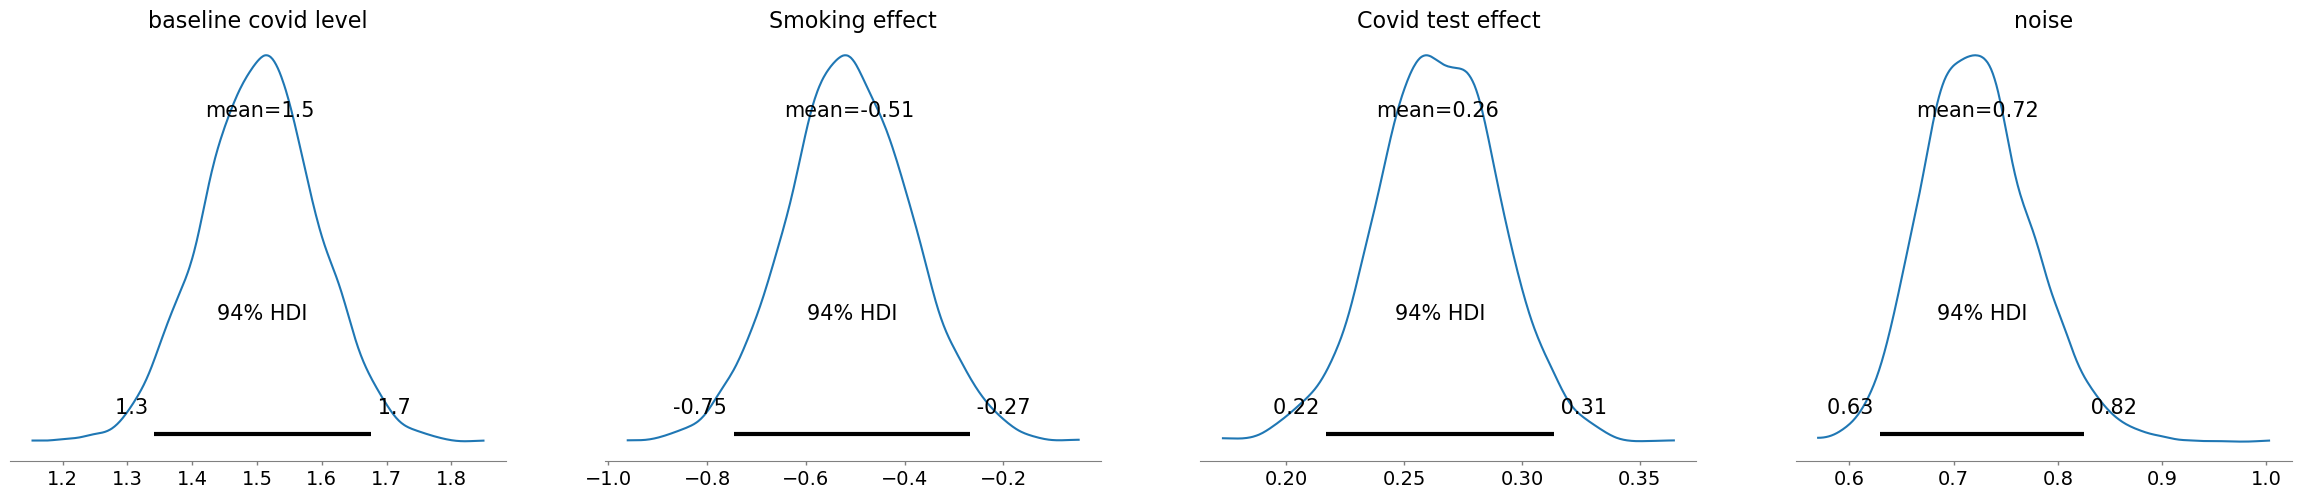

In [50]:
with pm.Model() as collider_bias:
    
    a = pm.Normal('baseline covid level',0,50)
    b1 = pm.Normal('Smoking effect',0,50)
    b2 = pm.Normal('Covid test effect',0,50)
    s = pm.Exponential('noise',1)
    
    mean = a + b1*smoking + b2*hospital
    
    y = pm.Normal('covid',mean,s,observed=covid)
    
    trace = pm.sample()
    
az.plot_posterior(trace);

I handled the pymc model for the restaurant problem and the covid problem into two different ways. In the restaurant problem, I filtered the data to only include what was left after we eliminate unprofitable businesses. In the covid problem, I included hospitalization as a causal variable in the linear function. Surprisingly, both techniques do the same thing.

In real life, hospitalization would also act as a filter. We would only get the data from those people who were hospitalized. But in this problem we are pretending to have data on everyone, hospitalized and non-hospitalized, and then looking at the association between hospitalization and covid. I do this just to show that filtering can act in similar ways to the other causal inference problems like common causes and mediation. Stilling a variable in your model is like assuming there is an arrowing flowing from hospitalization to covid. But that gets the cause structure backwards.

## Over-controlling and the problem with "Big Data"

Collider bias is a really interesting phenomena on its own and lurks behind dozens of silly news headlines ("10 habits of millionaires under 30"!!). I want to turn now to examples of colliders that are more relevant to your final projects. 

There is a common practice in scientific papers to include a number of "control" variables into a statistical model. The thought is very natural: sometimes we are studying a noisy system and we would like to try to "control" for or eliminate some of the noise with extra measurements. You all shared this thought when discussing the Bargh paper: lots of stuff causes variation in walking speed. Perhaps the priming effect is a fluke. And some of you also suggested that we collect measurements on our participants like height, pre-experiment walking speed, etc. I want to show that this natural thought can be very dangerous. Including extra variables into a statistical model is not harmless and can actively bias the inference.

Here's a simple illustration. Some scientists are interested in whether depression causes people to become more impulsive. Some participants in their study are regular users of opiates. The scientists suspect that might add an unnecessary source of noise to study. So they "control" for it by including it in the statistical model.

But let's imagine that this is the correct causal graph. Depression and impulsivity both cause people to use more opiates. Opiates are a collider. As we saw above, including opiates in the model can induce artificial correlations between depression and impulsivity. We don't really know how bad the bias could be. In the covid/smoking example, it was bad enough to flip the direction of causation.

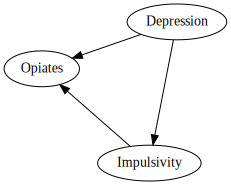

In [79]:
dot = Digraph()
dot.graph_attr['layout'] = 'neato'

dot.node("a",'Depression',pos="200,400")
dot.node("b",'Opiates',pos="0,200")
dot.node("c","Impulsivity",pos="100,0")

dot.edge("a",'b',len='2.0')
dot.edge("c",'b',len='2.0')
dot.edge("a",'c',len='2.0')

dot

This problem of over-controlling regularly shows up in what is often called "risk-factor" analysis. Loads of studies in psychiatry and health sciences more generally are interested in whether a certain variable increases the risk of some bad health outcome. My favourite example is a study on avocados. Lots of people wonder whether avocados are good or bad for your health. So some researchers found a group of 14,000 people and paid them to keep a food diary for a four year period. They then collected a variety of health information about them at regular intervals. On first glance, it looks like a great study. The sample is massive. However, in their statistical analysis they included the following addition variables into linear function:

![](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/controlling_for_everything.png)

My favourite bit is that they include **both** whole and chip tortillas in the list of controls. 

The trouble with this approach is that there is no theory about which of these things are colliders, which are common causes, which are mediators and which are just noise. Adding a bunch of stuff to a statistical model is just as likely to bias your inference as it is to improve it. The resulting output of the study is basically unintepretable as a causal inference. If someone was thinking to themself: should I eat more or less avocados, this study cannot help them with that question.

The lesson is that big data and big complex models are not, by themselves, virtues. To get effective inferences out of a study, you need to have a clear(-ish) idea of what is going on in the system you are studying. Statistics is a very modest tool that works best in the service of a clear scientific theory. It is not a replacement for good theory.

# The complete causal graph theory

Mediators, common causes and colliders exhaust all the ways you might connect three different nodes. There is no other way to connect three nodes.
(You might think - what about bi-directional causation? Great question, we'll come back to it at the end of the lecture.) Review these three examples. In every case, we want to know how much $A$ causes $C$. But we have to figure out whether to include or exclude $B$ in the statistical model.

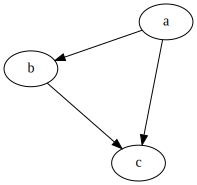

In [83]:
# mediator

dot = Digraph()
dot.graph_attr['layout'] = 'neato'

dot.node("a",'a',pos="200,400")
dot.node("b",'b',pos="0,200")
dot.node("c","c",pos="100,0")

dot.edge("a",'b',len='2.0')
dot.edge("b",'c',len='2.0')
dot.edge("a",'c',len='2.0')

dot

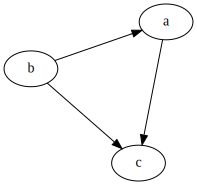

In [82]:
# common cause

dot = Digraph()
dot.graph_attr['layout'] = 'neato'

dot.node("a",'a',pos="200,400")
dot.node("b",'b',pos="0,200")
dot.node("c","c",pos="100,0")

dot.edge("b",'a',len='2.0')
dot.edge("b",'c',len='2.0')
dot.edge("a",'c',len='2.0')

dot

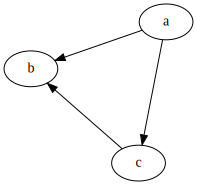

In [81]:
# collider

dot = Digraph()
dot.graph_attr['layout'] = 'neato'

dot.node("a",'a',pos="200,400")
dot.node("b",'b',pos="0,200")
dot.node("c","c",pos="100,0")

dot.edge("a",'b',len='2.0')
dot.edge("c",'b',len='2.0')
dot.edge("a",'c',len='2.0')

dot

Any more complicated graph can be decomposed into a series of triangular relationship. This means that if you understand how extract the correct causal estimates from each of these triangles, then you can understand how to extract the correct causal estimates from any more complex causal systems. Each type of triangle has it own rules.

**For mediators:**
> If you want the direct effect, do include the mediator as a causal variable
> If you want the total effect, do not include the mediator as a causal variable

**For common causes:**
> Always include the common cause as a causal variable

**For colliders:**
> Never include the collider as a causal variable

You might notice that mediators enable a distinction between direct and total effects but the other two don't. That's right - there are two different senses of "A causes C" in a mediation system because there are two pathways the causal influence can travel through. In the others, there is only a direct effect so you don't have to decide what kind of effect to look for.

In addition to the triangle rules, there are also some convenient way to simplify causal graphs. 

> Multiple noise terms can be regrouped into a single noise term as long as they have no causes

We saw this two classes ago when we introduced mediators. Here is a new trick though:

> Two nodes along a single causal pathways can be regrouped into a single node.

This rule essentially says these two causal graphs are equivalent:

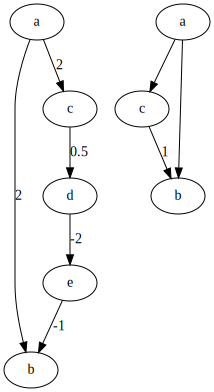

In [84]:
dot = Digraph()

dot.node("a")
dot.node("b")
dot.node("c")
dot.node("d")
dot.node("e")

dot.edge("a",'b','2')
dot.edge("c",'d','0.5')
dot.edge("d",'e','-2')
dot.edge("e",'b','-1')
dot.edge("a",'c','2')

dot.node("f","a")
dot.node("g","c")
dot.node("h","b")
dot.edge("f",'g')
dot.edge("g",'h','1')
dot.edge("f",'h')

dot

If you want a fine-grained causal representation, then the left hand-side is helpful. But if you don't care about all the subsystems, the right hand graph is okay. In both cases, if you want to learn the direct effect of $a$ on $b$, you should include $c$ because $c$ is a mediator in both cases. If you want to learn the total effect, you should exclude $c$.

There are some other surprising properties. For example, suppose there is some noise effecting c, d, and e. In this case, you can still regroup all the nodes. Here's a simulation to demonstrate:

In [85]:
n = 200

a = stats.norm(0,1).rvs(n)
c = 4*a + stats.norm(0,1).rvs(n)
d = 0.5*c + stats.norm(0,1).rvs(n)
e = -2*d + stats.norm(0,1).rvs(n)
b = -1*e + 2*a + stats.norm(0,1).rvs(n)

I've added noise onto everything. You might think that all this extra noise dilutes the causal effect along the long pathway. It doesn't! Here's a statistical model that just uses the $c$ from the long pathway.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, c effect, a effect, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


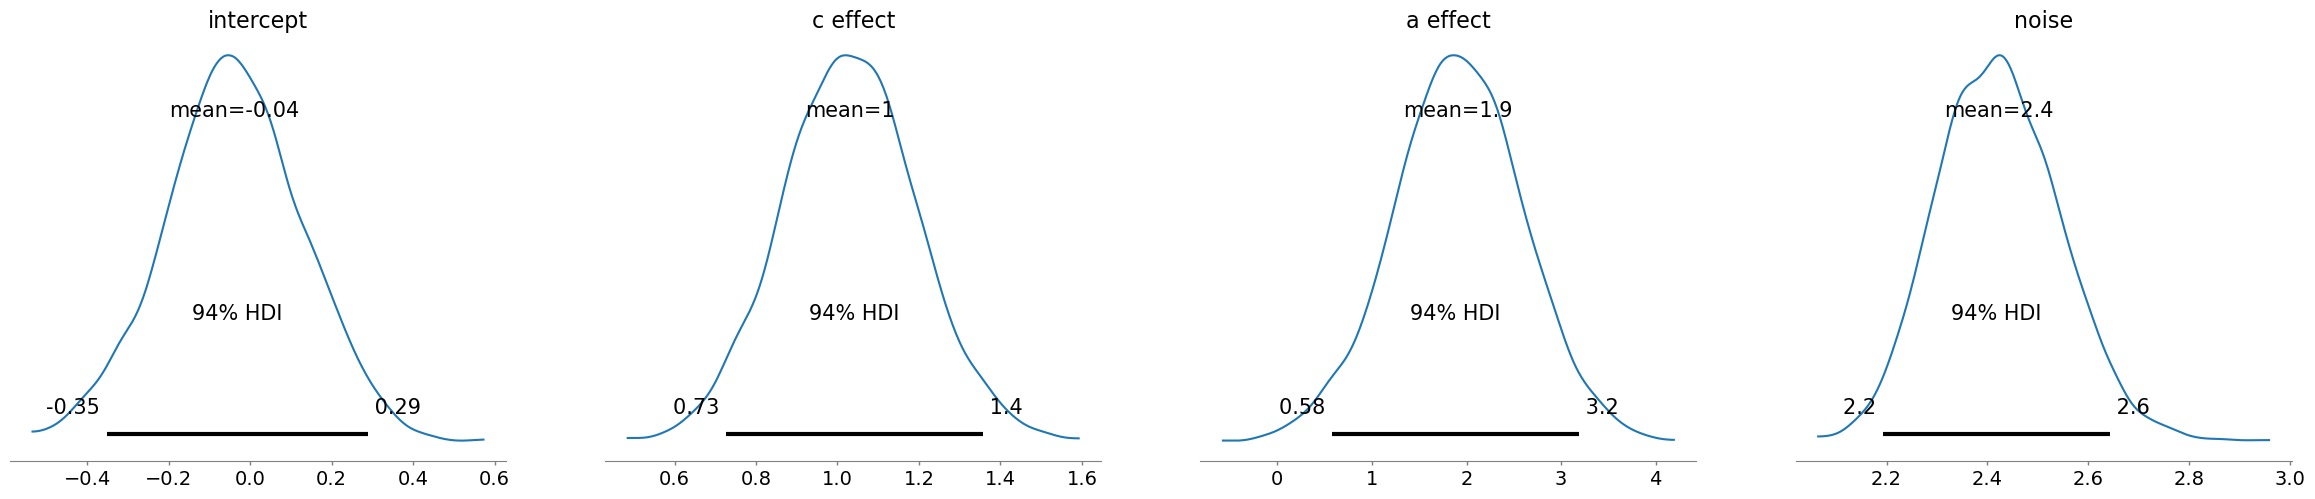

In [74]:
with pm.Model() as chain_reduction:
    
    intercept = pm.Normal('intercept',0,50)
    c_effect = pm.Normal('c effect',0,50)
    a_effect = pm.Normal('a effect',0,50)
    s = pm.Exponential('noise',1)
    
    mean = intercept + c_effect*c + a_effect*a
    
    y = pm.Normal('b',mean,s,observed=b)
    
    trace = pm.sample()
    
az.plot_posterior(trace);

Notice first that the statistical model correctly recovers the direct effect of $a$ on $b$ as 2. Notice second that the causal effect of $c$ is 1. Why would it be one?

Well, if you track how the causal influence along the chain works, it makes sense that it works out to 1. Going from c to d is 0.5. From d to e is -2. So that's like the total effect is 0.5 * -2 = -1. Finally, to go from e to b is -1. -1 * -1 is positive 1. Which is just what our statistical model found! 

The lesson is that if you include a node high up on a chain like this, you get the total causal effect through eachout the chain. 

We can probe the idea a little bit more. What if we include a node low on the chain, like $e$? 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, e effect, a effect, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


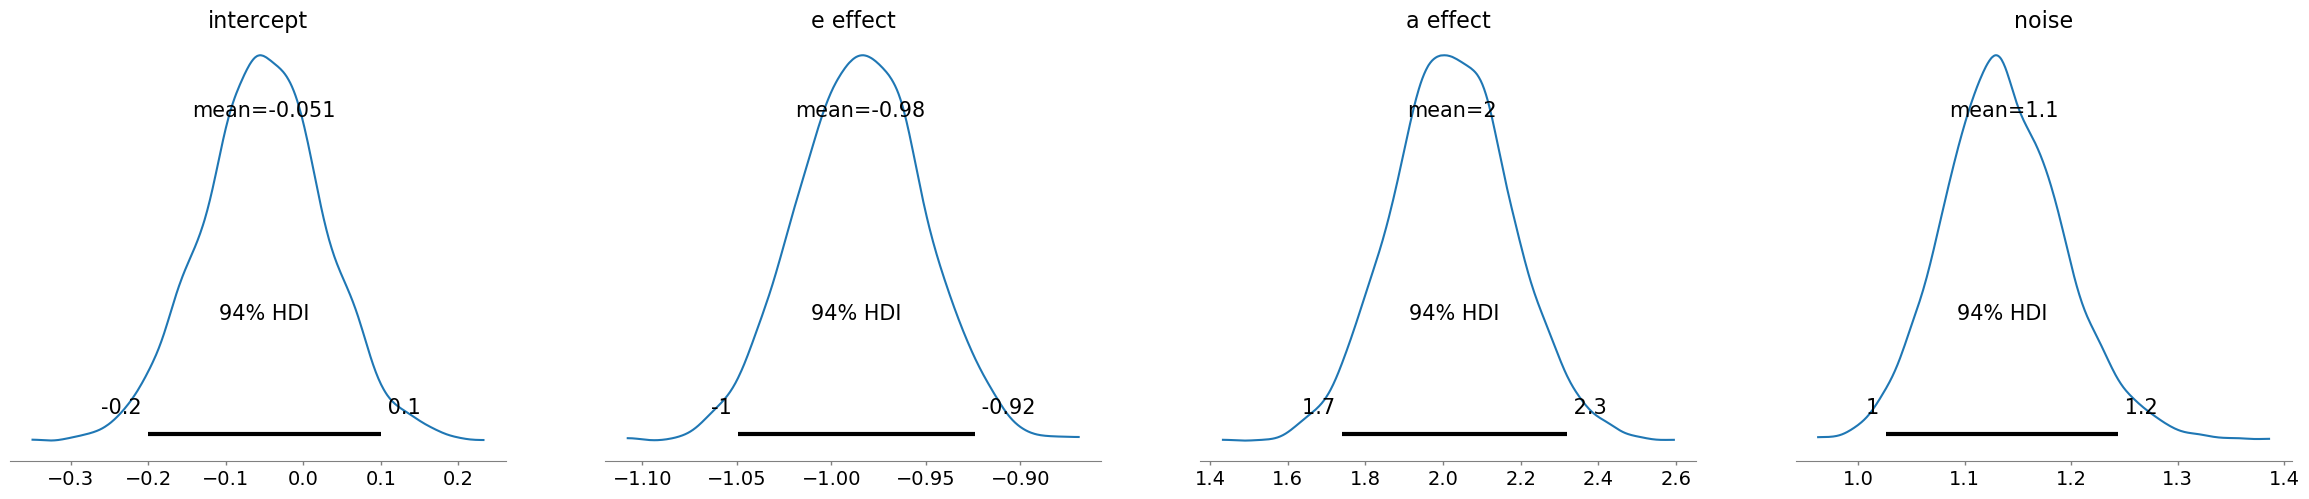

In [75]:
with pm.Model() as chain_reduction:
    
    intercept = pm.Normal('intercept',0,50)
    e_effect = pm.Normal('e effect',0,50)
    a_effect = pm.Normal('a effect',0,50)
    s = pm.Exponential('noise',1)
    
    mean = intercept + e_effect*e + a_effect*a
    
    y = pm.Normal('b',mean,s,observed=b)
    
    trace = pm.sample()
    
az.plot_posterior(trace);

Again, the $a$ effect is -2 and correctly identified. So the lesson there is it doesn't matter which node we include in the chain, so long as we include one. Finally, we also learn the direct effect of e on b is roughly -1, which is what the simulation said.

The point of all this is to just illustrate why the chain reduction trick works. It's okay to replace a long chain with a single node because it exhibits all these properties: the total causal effect is just a sequence of smaller causal effects and including any node in the chain is sufficient to recover the direct effect of $a$ on $b$.

## Some limitations of the causal graph theory

Something might have been bothering you during this whole discussion: what if two things cause each other. Opiates might cause depression and also depressed people are inclined toward opiates. Causal graph theory is extremely useful where it is applicable. But it's not applicable everyone. If you think about causation extended over a long period of time, there are are often cycles in the causal system. But it's a stipulation of the theory that we cannot do circles. For example, this is not allowed:

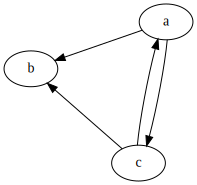

In [86]:
# collider

dot = Digraph()
dot.graph_attr['layout'] = 'neato'

dot.node("a",'a',pos="200,400")
dot.node("b",'b',pos="0,200")
dot.node("c","c",pos="100,0")

dot.edge("a",'b',len='2.0')
dot.edge("c",'b',len='2.0')
dot.edge("a",'c',len='2.0')
dot.edge("c","a",len="2.0")

dot

There are two ways to address this limitation. 

First, we might try to simplify the real world by breaking up into a series of instances. In each instance, causation might flow in one direction, even though in long run, causation flows in both directions. If a restaurant is deciding to relocate to increase profits, then location must be the cause of profits, not the other way around. However, at another point in time, profitability might enable a restaurant to relocate. In that cause, profits are a cause of location.

This strategy has it's limits. If data is collected over a long-period of time, than the data is a product of multiple causal loops. In that case, using linear functions to represent your system is poor choice. It's just not the case that profits are linear function of location and food quality when the system cycles. 

The second option is to explore dynamic systems models. We don't cover them in this class. But they are wonderful and wonderfully difficult to use.